In [1]:
%matplotlib inline

import sys, platform, os
import scipy.fftpack as fft
from scipy.integrate import quad, romberg
from scipy.special import spherical_jn as jn
from scipy.interpolate import interp1d,splev,splrep
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy.interpolate import InterpolatedUnivariateSpline
from timeit import default_timer as timer

sys.path.append('/Users/azadeh/Desktop/IR_resummation/codes/Azadeh/scripts/')
import EH_fit as EH


### CAMB
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
print('CAMB version: %s '%camb.__version__)

plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = [6, 4]

plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams["axes.labelsize"] = 16
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.minor.width'] = 0.6
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'on'
plt.rcParams['ytick.right'] = 'on'


CAMB version: 1.1.0 


# 1. Set the parmaeters of CAMB 

In [2]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122,  omk=0, tau=0.06)
pars.InitPower.set_params(As=2.e-9, ns=0.965, r=0, pivot_scalar = 0.05)
pars.set_matter_power(redshifts=[0.,10.0], kmax=30.0)
results = camb.get_results(pars)

### Compute the sigma8: note thaht the get_sigma8() function returns 
### of an array of values, in order of increasing time (decreasing redshift)
sigma8 = np.array(results.get_sigma8())   


# ka, pka       = np.loadtxt('/Users/azadeh/Desktop/IR_resummation/codes/Matteo/SplitW_NW/input/powL2000_gaussian_085_otherconvention_good.dat',unpack=True)
ka, pka       = np.loadtxt('/Volumes/Data/Documents/Git/gc-wp-nonlinear/linear_spectra_flagship/matter/high_res/flagship_linear_cb_hr_matterpower_z0p0.dat',unpack=True)
logpka        = np.log10(pka)
logka         = np.log10(ka)
logpka_interp = InterpolatedUnivariateSpline(logka,logpka,k=3)



Note: redshifts have been re-sorted (earliest first)


# 2. Compute matter power spectrum

In [3]:
PK_NL = camb.get_matter_power_interpolator(pars, nonlinear=True,hubble_units=True,k_hunit=True,zmax=1100,log_interp=True,k_per_logint=True,extrap_kmax=1000)
PK_L = camb.get_matter_power_interpolator(pars, nonlinear=False,hubble_units=True,k_hunit=True,zmax=1100,log_interp=True,k_per_logint=True,extrap_kmax=1000)

### Get the transfer functions, kh = 1, Transfer_cdm = 2, Transfer_b = 3, Transfer_tot = 7
# trans = data.get_matter_transfer_data()
# kh = trans.transfer_data[0,:,0]
# delta_cdm = trans.transfer_data[model.Transfer_cdm-1,:,0]
# delta_b = trans.transfer_data[model.Transfer_b-1,:,0]
# delta_tot = trans.transfer_data[model.Transfer_tot-1,:,0]

# print model.Transfer_cdm, model.Transfer_b, model.Transfer_tot
# Tcdm = delta_cdm/max(delta_cdm)
# Tb = delta_b/max(delta_b)
# Ttot = delta_tot/max(delta_tot)

# plt.loglog(kh,Tcdm/Ttot,label="cdm")
# plt.loglog(kh,Tb/Ttot,label="b")
# #plt.loglog(kh,Ttot,label="tot")
# # plt.xlim(1.e-3,1.)
# # plt.ylim(1.e-2,1.)
# plt.legend()
# plt.show()

# 3. Eisentein and Hu fit (astro-ph/9709112), load the functions from EH_fit module.

Plot the EH total matter, cdm, baryons and zero baryon transfer functions, the power spectrum and wiggle-only contribution to power spectrum

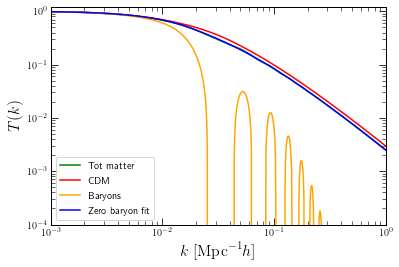

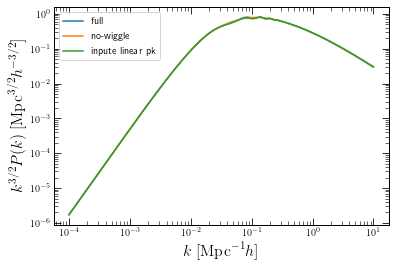

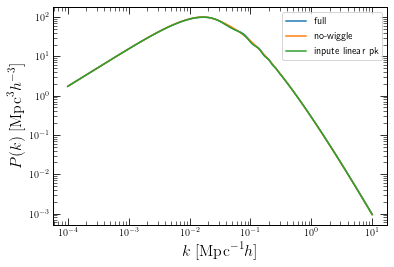

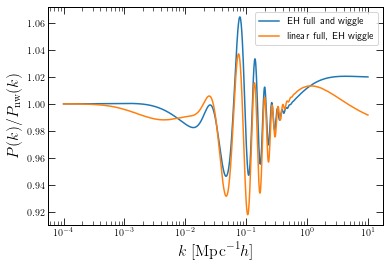

In [4]:
logks = np.linspace(-4.,1.,1000)
ks = (10.**logks)  ##ks in units of h/Mpc
kin = ks[0]
# pkin = PK_L.P(0,kin)
pkin = 10.**logpka_interp(np.log10(kin))/(2.*np.pi)**3.
pk = 10.**logpka_interp(np.log10(ks))/(2.*np.pi)**3.


plt.loglog(ks, EH.T(ks),"green", label="Tot matter")
plt.loglog(ks, EH.Tc(ks),"red", label="CDM")
plt.loglog(ks, EH.Tb(ks),"orange", label = "Baryons")
plt.loglog(ks, EH.T0(ks),"blue",label="Zero baryon fit")
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$T(k)$')
plt.xlim(1.e-3,1.)
plt.ylim(1e-4,1.2)
plt.legend()
plt.show()

plt.loglog(ks,ks**(3./2.)*EH.EH_PS_w(ks,kin,pkin), label="full")
plt.loglog(ks,ks**(3./2.)*EH.EH_PS_nw(ks,kin,pkin),label="no-wiggle")
plt.loglog(ks,ks**(3./2.)*pk, label = "inpute linear pk")
#plt.loglog(ks,(ks)**(3./2.)*PK_L.P(0,ks), label = "inpute linear pk")
# plt.xlim(4.e-3,5)
# plt.ylim(1.,300.)
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$k^{3/2}P(k)\; [\mathrm{Mpc}^{3/2} h^{-3/2}]$')
plt.legend()
plt.show()

plt.loglog(ks,EH.EH_PS_w(ks,kin,pkin), label="full")
plt.loglog(ks,EH.EH_PS_nw(ks,kin,pkin),label="no-wiggle")
plt.loglog(ks,pk, label = "inpute linear pk")
#plt.loglog(ks,PK_L.P(0,ks), label = "inpute linear pk")
# plt.xlim(8.e-3,4)
# plt.ylim(20.,150.)
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$P(k)\; [\mathrm{Mpc}^3 h^{-3}]$')
plt.legend()
plt.show()

plt.semilogx(ks,EH.EH_PS_w(ks,kin,pkin)/EH.EH_PS_nw(ks,kin,pkin),label="EH full and wiggle")
plt.semilogx(ks,pk/EH.EH_PS_nw(ks,kin,pkin),label = "linear full, EH wiggle")
#plt.semilogx(ks,PK_L.P(0,ks)/EH.EH_PS_nw(ks,kin,pkin),label = "linear full, EH wiggle")
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$P(k)/P_\mathrm{nw}(k)$')
plt.legend()
plt.show()


2. Do the wiggle no-wiggle split using the 1d Gaussian filtering in logaithmic space

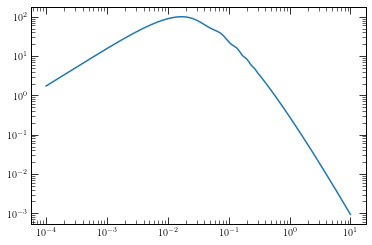

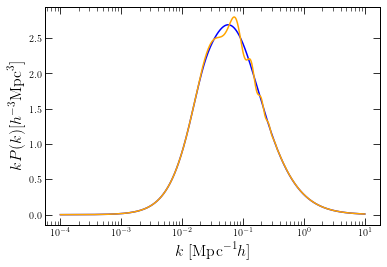

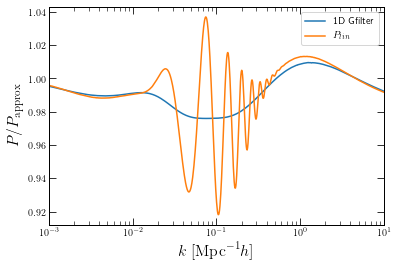

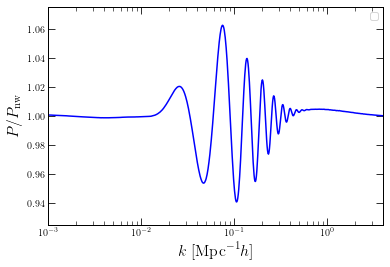

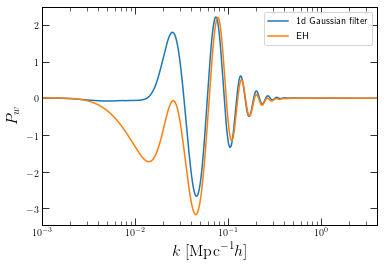

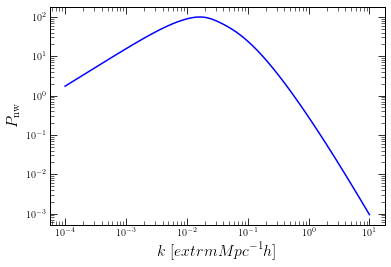

In [5]:
def pk(k):
    logk = np.log10(k)
    return 10.**logpka_interp(logk)/(2.*np.pi)**3.

def pk_approx(k,k0,p0):
    out = EH.EH_PS_nw(k,k0,p0)
    return out

def pk_nw_integrand(logq, k, k0, p0):
    q = 10.**logq
    logk = np.log10(k)
    a = 0.25 
 #   out =  PK_L.P(0,q)/pk_approx(q,k0,p0) * np.exp(-1./(2.*a**2.)*(logk-logq)**2.)
    out =  pk(q)/pk_approx(q,k0,p0) * np.exp(-1./(2.*a**2.)*(logk-logq)**2.)
    return out
        
def pk_nw(k,k0,p0):
    a = 0.25
    logqmin =  np.log10(k) - 4.* a
    logqmax =  np.log10(k) + 4.* a
    out = 1./(np.sqrt(2.*np.pi)* a)* quad(pk_nw_integrand, logqmin, logqmax, epsabs=0.,epsrel=1e-4, limit = 10000, args=(k,k0,p0))[0]
    return out

vec_pk_nw = np.vectorize(pk_nw)
p_nw = pk_approx(ks,kin,pkin)*vec_pk_nw(ks,kin,pkin)
#plin = PK_L.P(0,ks)
plin = pk(ks)
p_w  = plin - p_nw

# DataOut = np.column_stack((ks,p_w,p_nw))
# np.savetxt('pk_Gfilter.txt',DataOut,fmt=('%8f', '%8f', '%8f'))

p = p_w + p_nw
plt.loglog(ks,p)
plt.show()

plt.semilogx(ks,ks* p_nw, color= "blue")
#plt.semilogx(ks, ks*PK_L.P(0,ks), color="orange")
plt.semilogx(ks, ks*plin, color="orange")
# plt.xlim(0.004,2.)
# plt.ylim(0,700)
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$k P(k)[h^{-3} \mathrm{Mpc}^3]$')
plt.show()

plt.semilogx(ks,p_nw/pk_approx(ks,kin,pkin),label='1D  Gfilter')
#plt.semilogx(ks,PK_L.P(0,ks)/pk_approx(ks,kin,pkin),label = '$P_{lin}$')
plt.semilogx(ks,plin/pk_approx(ks,kin,pkin),label = '$P_{lin}$')
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$P/P_\mathrm{approx}$')
plt.xlim(0.001,10.)
# plt.ylim(0.9,1.03)
plt.legend()
plt.show()


#plt.semilogx(ks,PK_L.P(0,ks)/p_nw,'blue')
plt.semilogx(ks,plin/p_nw,'blue')
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$P/P_\mathrm{nw}$')
plt.xlim(0.001,4.)
plt.ylim(0.925,1.075)
plt.legend()
#plt.savefig('ratio_totw.png')
plt.show()

plt.semilogx(ks,p_w,label ="1d Gaussian filter")
plt.semilogx(ks,(EH.EH_PS_w(ks,kin,pkin)-EH.EH_PS_nw(ks,kin,pkin)), label ="EH")
plt.xlim(0.001,4.)
plt.xlabel('$k \; [\mathrm{Mpc}^{-1} h]$')
plt.ylabel('$P_w$')
#plt.savefig('w.png')
plt.legend()
plt.show()

plt.loglog(ks,p_nw,'blue')
plt.xlabel('$k \; [\textrm{Mpc}^{-1} h]$')
plt.ylabel('$P_\mathrm{nw}$')
# plt.xlim(1e-4,.8)
# plt.ylim(300.,3.e4)
#plt.savefig('nw.png')
plt.show()
